Основное задание:
Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые.


Внимание! выборка
assignment_2_test.csv
- наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод
fit
/
train
;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (
train
,
valid
);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (
train
,
valid
,
test
);
* ЛБ - лидерборд, выборка
assignment_2_test.csv
.

Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (
TransactionID
), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.


In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 400)

In [3]:
data = pd.read_csv("../assignment_2_train.csv")
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
data['isFraud'].value_counts()

0    174859
1      5141
Name: isFraud, dtype: int64

In [5]:
lb = pd.read_csv("../assignment_2_test.csv")
lb.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.0,T,T,F,M0,T,F,F,F,T,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0,0.0,1.0,1.0,2.0,6.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,452.0,1482.0,1482.0,0.0,206.0,206.0,452.0,1276.0,1276.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,14.0,7.0,9.0,15.0,0.0,2.0,0.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0

In [6]:
lb['isFraud'].value_counts()

0    96197
1     3804
Name: isFraud, dtype: int64

Тестовую выборку делаем размером 20%, ориентируясь на то, чтобы в ней было не менее 1000 целевых значений.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(["TransactionID", "isFraud"], axis=1), data["isFraud"], train_size=0.8, shuffle=True, random_state=1,
)

In [8]:
numerical_features = x_train.select_dtypes(exclude=["object"])
numerical_features = numerical_features.columns.tolist()

x_train = x_train[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 144000 rows, 378 cols
x_test.shape = 36000 rows, 378 cols


In [9]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc"
}

In [10]:
model = xgb.XGBClassifier(**params)
model.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=120,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.73561	validation_1-auc:0.73460
[10]	validation_0-auc:0.89716	validation_1-auc:0.87862
[20]	validation_0-auc:0.93243	validation_1-auc:0.90575
[30]	validation_0-auc:0.94761	validation_1-auc:0.91837
[40]	validation_0-auc:0.95537	validation_1-auc:0.92334
[50]	validation_0-auc:0.95998	validation_1-auc:0.92544
[60]	validation_0-auc:0.96661	validation_1-auc:0.92993
[70]	validation_0-auc:0.96926	validation_1-auc:0.93241
[80]	validation_0-auc:0.97184	validation_1-auc:0.93406
[90]	validation_0-auc:0.97537	validation_1-auc:0.93639
[99]	validation_0-auc:0.97769	validation_1-auc:0.93658


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [11]:
train_score = roc_auc_score(y_train, model.predict(x_train))
test_score = roc_auc_score(y_test, model.predict(x_test))

print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.824, Test-score: 0.753


In [12]:
train_score_p = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
test_score_p = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])

print(f"Train-score: {round(train_score_p, 3)}, Test-score: {round(test_score_p, 3)}")

Train-score: 0.978, Test-score: 0.937



Качество модели на валидационной выборке хорошее (достаточно приемлемый test-score). Расхождение по сравнению с качеством на обучающей выборке и валидационной выборке есть (трейн выше), что говорит о возможном небольшом переобучении. 

In [29]:
x_lb = lb[numerical_features]
y_lb = lb["isFraud"]
lb_score = roc_auc_score(y_lb, model.predict(x_lb))

In [30]:
print(f"LB-score: {round(lb_score, 3)}")

LB-score: 0.66



Качество на ЛБ существенно существенно хуже, чем на тренировочной выборке, и хуже чем на валидационной выборке, но при этом более-менее приемлемо. Вывод - модель переобучилась и нуждается в подборе гиперпараметров и, вероятно, в регуляризации.


Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки.

In [15]:
x_train2, x_valid, y_train2, y_valid = train_test_split(
    x_train, y_train, train_size=0.75, shuffle=True, random_state=1, # в такой пропорции получается 0.6, 0.2 и 0.2
)

In [16]:
print("x_train2.shape = {} rows, {} cols".format(*x_train2.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))



x_train2.shape = 108000 rows, 378 cols
x_valid.shape = 36000 rows, 378 cols
x_test.shape = 36000 rows, 378 cols


In [17]:
model2 = xgb.XGBClassifier(**params)
model2.fit(
    X=x_train2,
    y=y_train2,
    eval_set=[(x_train2, y_train2), (x_valid, y_valid)],
    early_stopping_rounds=120,
    eval_metric="auc",
    verbose=10
)

[0]	validation_0-auc:0.77448	validation_1-auc:0.75803
[10]	validation_0-auc:0.90016	validation_1-auc:0.87799
[20]	validation_0-auc:0.93717	validation_1-auc:0.90027
[30]	validation_0-auc:0.94979	validation_1-auc:0.90930
[40]	validation_0-auc:0.95910	validation_1-auc:0.91470
[50]	validation_0-auc:0.96451	validation_1-auc:0.91732
[60]	validation_0-auc:0.96930	validation_1-auc:0.92001
[70]	validation_0-auc:0.97410	validation_1-auc:0.91935
[80]	validation_0-auc:0.97689	validation_1-auc:0.92105
[90]	validation_0-auc:0.97989	validation_1-auc:0.92235
[99]	validation_0-auc:0.98249	validation_1-auc:0.92354


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [18]:
train_score2 = roc_auc_score(y_train2, model2.predict(x_train2))
valid_score2 = roc_auc_score(y_valid, model2.predict(x_valid))
test_score2 = roc_auc_score(y_test, model2.predict(x_test))

print(f"Train-score: {round(train_score2, 3)},Valid-score: {round(valid_score2, 3)}, Test-score: {round(test_score2, 3)}")

Train-score: 0.833,Valid-score: 0.736, Test-score: 0.739


In [19]:
train_score2 = roc_auc_score(y_train2, model2.predict_proba(x_train2)[:,1])
valid_score2 = roc_auc_score(y_valid, model2.predict_proba(x_valid)[:,1])
test_score2 = roc_auc_score(y_test, model2.predict_proba(x_test)[:,1])

print(f"Train-score: {round(train_score2, 3)},Valid-score: {round(valid_score2, 3)}, Test-score: {round(test_score2, 3)}")

Train-score: 0.982,Valid-score: 0.924, Test-score: 0.934



Качество модели на валидационной выборке и на тестовой почти совпадает с тестом предыдущего разбиения (существенно ниже тренировочной, что говорит о переобучении)


In [20]:
lb_score2 = roc_auc_score(y_lb, model2.predict(x_lb))

In [21]:
print(f"LB-score2 {round(lb_score2, 3)}")

LB-score2 0.651



Никаких изменений по сравнению с предыдущей моделью (что, в принципе, неудивительно, т.к. данные для обучения модели почти те же самые). Вывод - в данном случае доп. разбиение на валидационную выборку результата не изменило.


Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

In [22]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [23]:
np.random.seed(27)
scores = create_bootstrap_metrics(y_test, model2.predict(x_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.7242546233040607, 0.7552974019077795)

Text(0.5, 0, 'sample number')

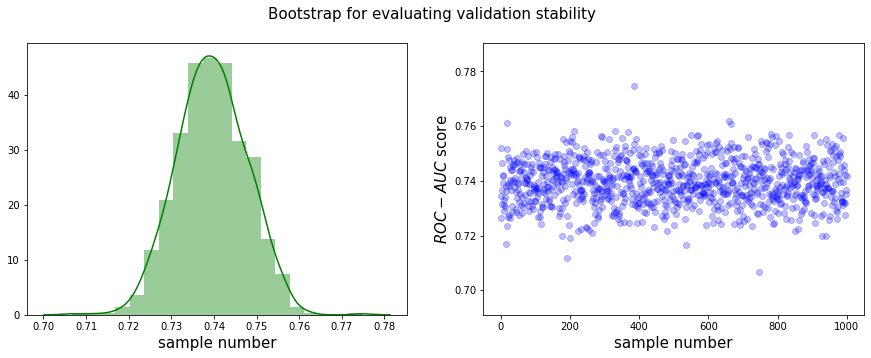

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("$ROC-AUC$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)

Вывод: доверительный интервал достаточно "узкий" (менее 10%). Однако, на ЛБ значение из него выпадает (ниже), поэтому вывод о переобучении модели остается

Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

In [25]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [26]:
cv_strategy = KFold(n_splits=5, random_state=1)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    data[numerical_features], data["isFraud"], model2, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.8338, valid-score = 0.6538
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.8294, valid-score = 0.6718
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.8218, valid-score = 0.7208
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.825, valid-score = 0.6867
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.8236, valid-score = 0.6819
CV-results train: 0.8267 +/- 0.004
CV-results valid: 0.683 +/- 0.022
OOF-score = 0.6812


Результаты CV на валидационной выборке близки к результатам на LB. Разброс результатов на валидационных фолдах небольшой (+/- 0.022). При этом минимальное значение валидации 0.6538, а LB-score2 = 0.651, т.е. почти попадает в интервал значений, полученных на KFold валидации.

Вывод - в данном случае KFold валидация дает адекватный результат, который подтверждается на LB

Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из
assignment_2_test.csv
, и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [32]:
x_adv = pd.concat([
    x_train, x_test, x_lb], axis=0
)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.zeros(x_test.shape[0]), np.ones(x_lb.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [33]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(x_adv, y_adv)

[23:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [34]:
y_pred_adv = model.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

1.0


In [42]:
y_pred = model.predict_proba(pd.concat([x_train, x_test], axis=0))
y_pred

array([[9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       ...,
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04],
       [9.997488e-01, 2.511662e-04]], dtype=float32)

In [43]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    180000
(0.1, 0.2]         0
(0.2, 0.3]         0
(0.3, 0.4]         0
(0.4, 0.5]         0
(0.5, 0.6]         0
(0.6, 0.7]         0
(0.7, 0.8]         0
(0.8, 0.9]         0
(0.9, 1.0]         0
dtype: int64

Вывод: Adversarial Validation показала идеальную разделяющую способность тренировочной выборки и LB . ПОэтому нет возможности выявить объекты из обучающей выборки, которые сильно похожи на объекты LB. Возможно, нужно провести отбор feature, убрав те из них, которые позволяют так хорошо разделять тренировочную выборку и LB.

Задание 6 (опциональное): сделать Hold-Out валидацию по времени (
TransactionDT
), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (
TransactionID
) и время транзакции (
TransactionDT
), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (
GroupKFold
).